In [1]:
import pandas as pd
import numpy as np

from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, norm

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf
import random

%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

In [2]:
# -- Load non-parametric dataset directly from data/processed/combined_spxusd.csv

import os
import pandas as pd

# Path to the non-parametric combined SPXUSD data (relative to project root)
data_path = os.path.abspath(os.path.join(
   "", "../../../data/processed/combined_spxusd.csv"
))
assert os.path.exists(data_path), f"Data file not found at {data_path}"

# The file has two columns, with no header: timestamp, price
spxusd = pd.read_csv(data_path)

In [3]:
# Compute log returns from the non-parametric price data in 'Close' column (see cell 1/context)
spxusdlog = np.log(spxusd['spxusd'] / spxusd['spxusd'].shift(1))[1:].values
mu = spxusdlog.mean()
std = spxusdlog.std()
print("Mean of spxusdlog:", mu)
print("Std of spxusdlog:", std)
print(spxusdlog.shape)

Mean of spxusdlog: 7.190544685448258e-07
Std of spxusdlog: 0.000252673010071939
(291378,)


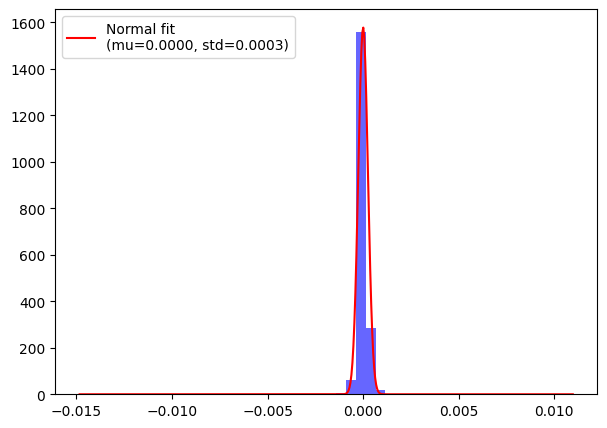

In [4]:
plt.hist(spxusdlog, bins=50, density=True, alpha=0.6, color='b')
mu, std = spxusdlog.mean(), spxusdlog.std()
x_axis = np.linspace(spxusdlog.min(), spxusdlog.max(), 500)
plt.plot(x_axis, norm.pdf(x_axis, mu, std), color='r', label=f'Normal fit\n(mu={mu:.4f}, std={std:.4f})')
plt.legend()
plt.show()

In [5]:
def delta_init(z):
    k = kurtosis(z, fisher=False, bias=False)
    if k < 166. / 62.:
        return 0.01
    return np.clip(1. / 66 * (np.sqrt(66 * k - 162.) - 6.), 0.01, 0.48)

def delta_gmm(z):
    delta = delta_init(z)

    def iter(q):
        u = W_delta(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        k = kurtosis(u, fisher=True, bias=False)**2
        if not np.isfinite(k) or k > 1e10:
            return 1e10
        return k

    res = fmin(iter, np.log(delta), disp=0)
    return np.around(np.exp(res[-1]), 6)

def W_delta(z, delta):
    return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)

def W_params(z, params):
    return params[0] + params[1] * W_delta((z - params[0]) / params[1], params[2])

def inverse(z, params):
    return params[0] + params[1] * (z * np.exp(z * z * (params[2] * 0.5)))

def igmm(z, eps=1e-6, max_iter=100):
    delta = delta_init(z)
    params = [np.median(z), np.std(z) * (1. - 2. * delta) ** 0.75, delta]
    for k in range(max_iter):
        params_old = params
        u = (z - params[0]) / params[1]
        params[2] = delta_gmm(u)
        x = W_params(z, params)
        params[0], params[1] = np.mean(x), np.std(x)

        if np.linalg.norm(np.array(params) - np.array(params_old)) < eps:
            break
        if k == max_iter - 1:
            raise "Solution not found"

    return params

In [6]:
spxusdlog_mean = np.mean(spxusdlog)
spxusdlog_norm = spxusdlog - spxusdlog_mean
params = igmm(spxusdlog_norm)
spxusdprocessed = W_delta((spxusdlog_norm - params[0]) / params[1], params[2])
spxusdmax = np.max(np.abs(spxusdprocessed))
spxusdprocessed /= spxusdmax
spxusdprocessed = np.expand_dims(spxusdprocessed, axis=-1)
# spxusdprocessed = spxusdprocessed[:3000]
spxusdprocessed.shape

(291378, 1)

In [5]:
spxusdprocessed = np.expand_dims(spxusdlog, axis=-1)
# spxusdprocessed = spxusdprocessed[:5000]
spxusdprocessed.shape

(291378, 1)

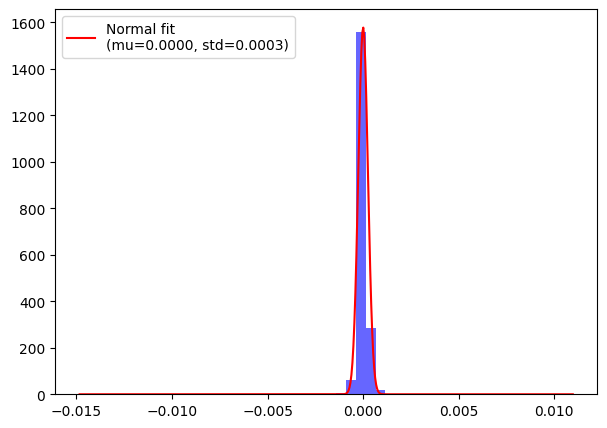

In [6]:
plt.hist(spxusdprocessed, bins=50, density=True, alpha=0.6, color='b')
mu, std = spxusdprocessed.mean(), spxusdprocessed.std()
x_axis = np.linspace(spxusdprocessed.min(), spxusdprocessed.max(), 500)
plt.plot(x_axis, norm.pdf(x_axis, mu, std), color='r', label=f'Normal fit\n(mu={mu:.4f}, std={std:.4f})')
plt.legend()
plt.show()

In [7]:
class SP500Dataset(Dataset):
    def __init__(self, data, window, percent=0.24, seed=42):
        self.data = data
        self.window = window
        num_windows = len(self.data) - self.window
        total_indices = np.arange(num_windows)
        rng = np.random.default_rng(seed)
        num_to_select = max(1, int(np.floor(percent * num_windows)))
        self.selected_indices = rng.choice(total_indices, size=num_to_select, replace=False)
        self.selected_indices.sort()  # Optional: keep sequential order

    def __getitem__(self, idx):
        index = self.selected_indices[idx]
        x = np.expand_dims(self.data[index:index+self.window], -1)
        return torch.from_numpy(x).float()

    def __len__(self):
        return len(self.selected_indices)

In [8]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs, kernel_size, dilation):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_hidden, kernel_size, stride=1, dilation=dilation, padding='same')

        self.relu1 = nn.PReLU()
        self.conv2 = nn.Conv1d(n_hidden, n_outputs, kernel_size, stride=1, dilation=dilation, padding='same')
        self.relu2 = nn.PReLU()

        self.net = nn.Sequential(self.conv1, self.relu1, self.conv2, self.relu2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None

        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=80):
        super(TCN, self).__init__()
        layers = []
        for i in range(7):
            num_inputs = input_size if i == 0 else n_hidden
            kernel_size = 2 if i > 0 else 1
            dilation = 2 * dilation if i > 1 else 1
            layers += [TemporalBlock(num_inputs, n_hidden, n_hidden, kernel_size, dilation)]
        self.conv = nn.Conv1d(n_hidden, output_size, 1)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        self.conv.weight.data.normal_(0, 0.01)
    
    def forward(self, x):
        y1 = self.net(x.transpose(1, 2))
        return self.conv(y1).transpose(1, 2)

class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
        return torch.tanh(self.net(x))

class Discriminator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
        return torch.sigmoid(self.net(x))

In [9]:
clip_value = 0.01
lr = 0.0002
num_epochs = 50
nz = 3
batch_size = 32
seq_len = 52

netG = Generator(nz, 1).to(device)
netD = Discriminator(1, 1).to(device)
optD = optim.RMSprop(netD.parameters(), lr=lr)
optG = optim.RMSprop(netG.parameters(), lr=lr)

dataset = SP500Dataset(spxusdprocessed, seq_len)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
t = tqdm(range(num_epochs))
for epoch in t:
    import time
    for i, data in enumerate(dataloader, 0):
        batch_start_time = time.time()

        netD.zero_grad()
        real = data.to(device).squeeze(-1)
        batch_size, seq_len = real.size(0), real.size(1)
        noise = torch.randn(batch_size, seq_len, nz, device=device)
        fake = netG(noise).detach()

        lossD = -torch.mean(netD(real)) + torch.mean(netD(fake))
        lossD.backward()
        optD.step()

        for p in netD.parameters():
            p.data.clamp_(-clip_value, clip_value)
  
        if i % 5 == 0:
            netG.zero_grad()
            lossG = -torch.mean(netD(netG(noise)))
            lossG.backward()
            optG.step()

        # Print out epoch, time, and batch iteration
        batch_end_time = time.time()
        print(f"Epoch {epoch+1}, Batch {i+1}/{len(dataloader)}, Time per batch: {batch_end_time - batch_start_time:.4f} seconds")
        
    #Report metrics
    t.set_description('Loss_D: %.8f Loss_G: %.8f' % (lossD.item(), lossG.item()))

  0%|          | 0/50 [00:00<?, ?it/s]/Users/eddisonpham/Projects/Unified-benchmark-for-SDGFTS/.venv/lib/python3.13/site-packages/torch/nn/modules/conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1032.)
  return F.conv1d(


Epoch 1, Batch 1/2185, Time per batch: 0.4608 seconds
Epoch 1, Batch 2/2185, Time per batch: 0.1919 seconds
Epoch 1, Batch 3/2185, Time per batch: 0.1855 seconds
Epoch 1, Batch 4/2185, Time per batch: 0.1910 seconds
Epoch 1, Batch 5/2185, Time per batch: 0.2112 seconds
Epoch 1, Batch 6/2185, Time per batch: 0.3272 seconds
Epoch 1, Batch 7/2185, Time per batch: 0.1960 seconds
Epoch 1, Batch 8/2185, Time per batch: 0.1922 seconds
Epoch 1, Batch 9/2185, Time per batch: 0.1877 seconds
Epoch 1, Batch 10/2185, Time per batch: 0.1851 seconds
Epoch 1, Batch 11/2185, Time per batch: 0.3544 seconds
Epoch 1, Batch 12/2185, Time per batch: 0.1970 seconds
Epoch 1, Batch 13/2185, Time per batch: 0.1954 seconds
Epoch 1, Batch 14/2185, Time per batch: 0.1916 seconds
Epoch 1, Batch 15/2185, Time per batch: 0.1907 seconds
Epoch 1, Batch 16/2185, Time per batch: 0.3441 seconds
Epoch 1, Batch 17/2185, Time per batch: 0.1959 seconds
Epoch 1, Batch 18/2185, Time per batch: 0.1905 seconds
Epoch 1, Batch 19/2

Loss_D: 0.00000006 Loss_G: -0.50261170:   2%|▏         | 1/50 [07:36<6:12:52, 456.59s/it]

Epoch 1, Batch 2185/2185, Time per batch: 0.1731 seconds
Epoch 2, Batch 1/2185, Time per batch: 0.3154 seconds
Epoch 2, Batch 2/2185, Time per batch: 0.1853 seconds
Epoch 2, Batch 3/2185, Time per batch: 0.1833 seconds
Epoch 2, Batch 4/2185, Time per batch: 0.1803 seconds
Epoch 2, Batch 5/2185, Time per batch: 0.1817 seconds
Epoch 2, Batch 6/2185, Time per batch: 0.3134 seconds
Epoch 2, Batch 7/2185, Time per batch: 0.1801 seconds
Epoch 2, Batch 8/2185, Time per batch: 0.1801 seconds
Epoch 2, Batch 9/2185, Time per batch: 0.1798 seconds
Epoch 2, Batch 10/2185, Time per batch: 0.1803 seconds
Epoch 2, Batch 11/2185, Time per batch: 0.3137 seconds
Epoch 2, Batch 12/2185, Time per batch: 0.1796 seconds
Epoch 2, Batch 13/2185, Time per batch: 0.1799 seconds
Epoch 2, Batch 14/2185, Time per batch: 0.1807 seconds
Epoch 2, Batch 15/2185, Time per batch: 0.1796 seconds
Epoch 2, Batch 16/2185, Time per batch: 0.3139 seconds
Epoch 2, Batch 17/2185, Time per batch: 0.1800 seconds
Epoch 2, Batch 18

Loss_D: 0.00000089 Loss_G: -0.50241888:   4%|▍         | 2/50 [15:10<6:04:01, 455.04s/it]

Epoch 2, Batch 2185/2185, Time per batch: 0.1733 seconds
Epoch 3, Batch 1/2185, Time per batch: 0.3149 seconds
Epoch 3, Batch 2/2185, Time per batch: 0.1810 seconds
Epoch 3, Batch 3/2185, Time per batch: 0.1802 seconds
Epoch 3, Batch 4/2185, Time per batch: 0.1790 seconds
Epoch 3, Batch 5/2185, Time per batch: 0.1808 seconds
Epoch 3, Batch 6/2185, Time per batch: 0.3142 seconds
Epoch 3, Batch 7/2185, Time per batch: 0.1806 seconds
Epoch 3, Batch 8/2185, Time per batch: 0.1802 seconds
Epoch 3, Batch 9/2185, Time per batch: 0.1801 seconds
Epoch 3, Batch 10/2185, Time per batch: 0.1803 seconds
Epoch 3, Batch 11/2185, Time per batch: 0.3140 seconds
Epoch 3, Batch 12/2185, Time per batch: 0.1802 seconds
Epoch 3, Batch 13/2185, Time per batch: 0.1804 seconds
Epoch 3, Batch 14/2185, Time per batch: 0.1794 seconds
Epoch 3, Batch 15/2185, Time per batch: 0.1795 seconds
Epoch 3, Batch 16/2185, Time per batch: 0.3140 seconds
Epoch 3, Batch 17/2185, Time per batch: 0.1797 seconds
Epoch 3, Batch 18

Loss_D: 0.00000000 Loss_G: -0.50213325:   6%|▌         | 3/50 [22:44<5:55:58, 454.44s/it]

Epoch 3, Batch 2185/2185, Time per batch: 0.1726 seconds
Epoch 4, Batch 1/2185, Time per batch: 0.3149 seconds
Epoch 4, Batch 2/2185, Time per batch: 0.1799 seconds
Epoch 4, Batch 3/2185, Time per batch: 0.1803 seconds
Epoch 4, Batch 4/2185, Time per batch: 0.1798 seconds
Epoch 4, Batch 5/2185, Time per batch: 0.1799 seconds
Epoch 4, Batch 6/2185, Time per batch: 0.3144 seconds
Epoch 4, Batch 7/2185, Time per batch: 0.1799 seconds
Epoch 4, Batch 8/2185, Time per batch: 0.1795 seconds
Epoch 4, Batch 9/2185, Time per batch: 0.1809 seconds
Epoch 4, Batch 10/2185, Time per batch: 0.1812 seconds
Epoch 4, Batch 11/2185, Time per batch: 0.3155 seconds
Epoch 4, Batch 12/2185, Time per batch: 0.1797 seconds
Epoch 4, Batch 13/2185, Time per batch: 0.1803 seconds
Epoch 4, Batch 14/2185, Time per batch: 0.1802 seconds
Epoch 4, Batch 15/2185, Time per batch: 0.1805 seconds
Epoch 4, Batch 16/2185, Time per batch: 0.3128 seconds
Epoch 4, Batch 17/2185, Time per batch: 0.1788 seconds
Epoch 4, Batch 18

Loss_D: -0.00000042 Loss_G: -0.50054538:   8%|▊         | 4/50 [30:18<5:48:12, 454.17s/it]

Epoch 4, Batch 2185/2185, Time per batch: 0.1732 seconds
Epoch 5, Batch 1/2185, Time per batch: 0.3143 seconds
Epoch 5, Batch 2/2185, Time per batch: 0.1802 seconds
Epoch 5, Batch 3/2185, Time per batch: 0.1817 seconds
Epoch 5, Batch 4/2185, Time per batch: 0.1795 seconds
Epoch 5, Batch 5/2185, Time per batch: 0.1806 seconds
Epoch 5, Batch 6/2185, Time per batch: 0.3142 seconds
Epoch 5, Batch 7/2185, Time per batch: 0.1799 seconds
Epoch 5, Batch 8/2185, Time per batch: 0.1813 seconds
Epoch 5, Batch 9/2185, Time per batch: 0.1803 seconds
Epoch 5, Batch 10/2185, Time per batch: 0.1802 seconds
Epoch 5, Batch 11/2185, Time per batch: 0.3150 seconds
Epoch 5, Batch 12/2185, Time per batch: 0.1795 seconds
Epoch 5, Batch 13/2185, Time per batch: 0.1798 seconds
Epoch 5, Batch 14/2185, Time per batch: 0.1810 seconds
Epoch 5, Batch 15/2185, Time per batch: 0.1790 seconds
Epoch 5, Batch 16/2185, Time per batch: 0.3149 seconds
Epoch 5, Batch 17/2185, Time per batch: 0.1806 seconds
Epoch 5, Batch 18

Loss_D: -0.00000036 Loss_G: -0.50036752:  10%|█         | 5/50 [37:52<5:40:39, 454.22s/it]

Epoch 5, Batch 2185/2185, Time per batch: 0.1723 seconds
Epoch 6, Batch 1/2185, Time per batch: 0.3173 seconds
Epoch 6, Batch 2/2185, Time per batch: 0.1828 seconds
Epoch 6, Batch 3/2185, Time per batch: 0.1789 seconds
Epoch 6, Batch 4/2185, Time per batch: 0.1809 seconds
Epoch 6, Batch 5/2185, Time per batch: 0.1808 seconds
Epoch 6, Batch 6/2185, Time per batch: 0.3178 seconds
Epoch 6, Batch 7/2185, Time per batch: 0.1801 seconds
Epoch 6, Batch 8/2185, Time per batch: 0.1798 seconds
Epoch 6, Batch 9/2185, Time per batch: 0.1804 seconds
Epoch 6, Batch 10/2185, Time per batch: 0.1807 seconds
Epoch 6, Batch 11/2185, Time per batch: 0.3139 seconds
Epoch 6, Batch 12/2185, Time per batch: 0.1801 seconds
Epoch 6, Batch 13/2185, Time per batch: 0.1822 seconds
Epoch 6, Batch 14/2185, Time per batch: 0.1804 seconds
Epoch 6, Batch 15/2185, Time per batch: 0.1794 seconds
Epoch 6, Batch 16/2185, Time per batch: 0.3137 seconds
Epoch 6, Batch 17/2185, Time per batch: 0.1795 seconds
Epoch 6, Batch 18

Loss_D: 0.00000012 Loss_G: -0.50195938:  12%|█▏        | 6/50 [45:26<5:32:59, 454.07s/it] 

Epoch 6, Batch 2185/2185, Time per batch: 0.1726 seconds
Epoch 7, Batch 1/2185, Time per batch: 0.3155 seconds
Epoch 7, Batch 2/2185, Time per batch: 0.1797 seconds
Epoch 7, Batch 3/2185, Time per batch: 0.1798 seconds
Epoch 7, Batch 4/2185, Time per batch: 0.1793 seconds
Epoch 7, Batch 5/2185, Time per batch: 0.1804 seconds
Epoch 7, Batch 6/2185, Time per batch: 0.3153 seconds
Epoch 7, Batch 7/2185, Time per batch: 0.1793 seconds
Epoch 7, Batch 8/2185, Time per batch: 0.1790 seconds
Epoch 7, Batch 9/2185, Time per batch: 0.1801 seconds
Epoch 7, Batch 10/2185, Time per batch: 0.1802 seconds
Epoch 7, Batch 11/2185, Time per batch: 0.3148 seconds
Epoch 7, Batch 12/2185, Time per batch: 0.1800 seconds
Epoch 7, Batch 13/2185, Time per batch: 0.1795 seconds
Epoch 7, Batch 14/2185, Time per batch: 0.1798 seconds
Epoch 7, Batch 15/2185, Time per batch: 0.1808 seconds
Epoch 7, Batch 16/2185, Time per batch: 0.3147 seconds
Epoch 7, Batch 17/2185, Time per batch: 0.1809 seconds
Epoch 7, Batch 18

Loss_D: 0.00000012 Loss_G: -0.50233018:  14%|█▍        | 7/50 [53:00<5:25:26, 454.11s/it]

Epoch 7, Batch 2185/2185, Time per batch: 0.1727 seconds
Epoch 8, Batch 1/2185, Time per batch: 0.3143 seconds
Epoch 8, Batch 2/2185, Time per batch: 0.1795 seconds
Epoch 8, Batch 3/2185, Time per batch: 0.1795 seconds
Epoch 8, Batch 4/2185, Time per batch: 0.1805 seconds
Epoch 8, Batch 5/2185, Time per batch: 0.1804 seconds
Epoch 8, Batch 6/2185, Time per batch: 0.3140 seconds
Epoch 8, Batch 7/2185, Time per batch: 0.1800 seconds
Epoch 8, Batch 8/2185, Time per batch: 0.1797 seconds
Epoch 8, Batch 9/2185, Time per batch: 0.1795 seconds
Epoch 8, Batch 10/2185, Time per batch: 0.1798 seconds
Epoch 8, Batch 11/2185, Time per batch: 0.3131 seconds
Epoch 8, Batch 12/2185, Time per batch: 0.1795 seconds
Epoch 8, Batch 13/2185, Time per batch: 0.1803 seconds
Epoch 8, Batch 14/2185, Time per batch: 0.1800 seconds
Epoch 8, Batch 15/2185, Time per batch: 0.1803 seconds
Epoch 8, Batch 16/2185, Time per batch: 0.3157 seconds
Epoch 8, Batch 17/2185, Time per batch: 0.1787 seconds
Epoch 8, Batch 18

Loss_D: 0.00000000 Loss_G: -0.50165105:  16%|█▌        | 8/50 [1:00:34<5:17:56, 454.20s/it]

Epoch 8, Batch 2185/2185, Time per batch: 0.1729 seconds
Epoch 9, Batch 1/2185, Time per batch: 0.3150 seconds
Epoch 9, Batch 2/2185, Time per batch: 0.1797 seconds
Epoch 9, Batch 3/2185, Time per batch: 0.1804 seconds
Epoch 9, Batch 4/2185, Time per batch: 0.1806 seconds
Epoch 9, Batch 5/2185, Time per batch: 0.1806 seconds
Epoch 9, Batch 6/2185, Time per batch: 0.3143 seconds
Epoch 9, Batch 7/2185, Time per batch: 0.1833 seconds
Epoch 9, Batch 8/2185, Time per batch: 0.2672 seconds
Epoch 9, Batch 9/2185, Time per batch: 0.1812 seconds
Epoch 9, Batch 10/2185, Time per batch: 0.1875 seconds
Epoch 9, Batch 11/2185, Time per batch: 0.3162 seconds
Epoch 9, Batch 12/2185, Time per batch: 0.1821 seconds
Epoch 9, Batch 13/2185, Time per batch: 0.1845 seconds
Epoch 9, Batch 14/2185, Time per batch: 0.1809 seconds
Epoch 9, Batch 15/2185, Time per batch: 0.1810 seconds
Epoch 9, Batch 16/2185, Time per batch: 0.3147 seconds
Epoch 9, Batch 17/2185, Time per batch: 0.1801 seconds
Epoch 9, Batch 18

Loss_D: 0.00000024 Loss_G: -0.50249517:  18%|█▊        | 9/50 [1:08:09<5:10:23, 454.24s/it]

Epoch 9, Batch 2185/2185, Time per batch: 0.1732 seconds
Epoch 10, Batch 1/2185, Time per batch: 0.3157 seconds
Epoch 10, Batch 2/2185, Time per batch: 0.1803 seconds
Epoch 10, Batch 3/2185, Time per batch: 0.1801 seconds
Epoch 10, Batch 4/2185, Time per batch: 0.1798 seconds
Epoch 10, Batch 5/2185, Time per batch: 0.1806 seconds
Epoch 10, Batch 6/2185, Time per batch: 0.3166 seconds
Epoch 10, Batch 7/2185, Time per batch: 0.1801 seconds
Epoch 10, Batch 8/2185, Time per batch: 0.1799 seconds
Epoch 10, Batch 9/2185, Time per batch: 0.1804 seconds
Epoch 10, Batch 10/2185, Time per batch: 0.1792 seconds
Epoch 10, Batch 11/2185, Time per batch: 0.3143 seconds
Epoch 10, Batch 12/2185, Time per batch: 0.1798 seconds
Epoch 10, Batch 13/2185, Time per batch: 0.1806 seconds
Epoch 10, Batch 14/2185, Time per batch: 0.1794 seconds
Epoch 10, Batch 15/2185, Time per batch: 0.1799 seconds
Epoch 10, Batch 16/2185, Time per batch: 0.3150 seconds
Epoch 10, Batch 17/2185, Time per batch: 0.1801 seconds


Loss_D: -0.00000024 Loss_G: -0.50215602:  20%|██        | 10/50 [1:15:42<5:02:43, 454.08s/it]

Epoch 10, Batch 2185/2185, Time per batch: 0.1728 seconds
Epoch 11, Batch 1/2185, Time per batch: 0.3155 seconds
Epoch 11, Batch 2/2185, Time per batch: 0.1799 seconds
Epoch 11, Batch 3/2185, Time per batch: 0.1789 seconds
Epoch 11, Batch 4/2185, Time per batch: 0.1790 seconds
Epoch 11, Batch 5/2185, Time per batch: 0.1792 seconds
Epoch 11, Batch 6/2185, Time per batch: 0.3142 seconds
Epoch 11, Batch 7/2185, Time per batch: 0.1794 seconds
Epoch 11, Batch 8/2185, Time per batch: 0.1798 seconds
Epoch 11, Batch 9/2185, Time per batch: 0.1800 seconds
Epoch 11, Batch 10/2185, Time per batch: 0.1803 seconds
Epoch 11, Batch 11/2185, Time per batch: 0.3139 seconds
Epoch 11, Batch 12/2185, Time per batch: 0.1797 seconds
Epoch 11, Batch 13/2185, Time per batch: 0.1798 seconds
Epoch 11, Batch 14/2185, Time per batch: 0.1805 seconds
Epoch 11, Batch 15/2185, Time per batch: 0.1799 seconds
Epoch 11, Batch 16/2185, Time per batch: 0.3139 seconds
Epoch 11, Batch 17/2185, Time per batch: 0.1799 seconds

Loss_D: 0.00000000 Loss_G: -0.50131100:  22%|██▏       | 11/50 [1:23:16<4:55:05, 453.99s/it] 

Epoch 11, Batch 2185/2185, Time per batch: 0.1727 seconds
Epoch 12, Batch 1/2185, Time per batch: 0.3144 seconds
Epoch 12, Batch 2/2185, Time per batch: 0.1803 seconds
Epoch 12, Batch 3/2185, Time per batch: 0.1811 seconds
Epoch 12, Batch 4/2185, Time per batch: 0.1799 seconds
Epoch 12, Batch 5/2185, Time per batch: 0.1793 seconds
Epoch 12, Batch 6/2185, Time per batch: 0.3127 seconds
Epoch 12, Batch 7/2185, Time per batch: 0.1804 seconds
Epoch 12, Batch 8/2185, Time per batch: 0.1793 seconds
Epoch 12, Batch 9/2185, Time per batch: 0.1805 seconds
Epoch 12, Batch 10/2185, Time per batch: 0.1808 seconds
Epoch 12, Batch 11/2185, Time per batch: 0.3137 seconds
Epoch 12, Batch 12/2185, Time per batch: 0.1811 seconds
Epoch 12, Batch 13/2185, Time per batch: 0.1793 seconds
Epoch 12, Batch 14/2185, Time per batch: 0.1794 seconds
Epoch 12, Batch 15/2185, Time per batch: 0.1802 seconds
Epoch 12, Batch 16/2185, Time per batch: 0.3147 seconds
Epoch 12, Batch 17/2185, Time per batch: 0.1803 seconds

Loss_D: -0.00000012 Loss_G: -0.50071961:  24%|██▍       | 12/50 [1:30:50<4:47:34, 454.07s/it]

Epoch 12, Batch 2185/2185, Time per batch: 0.1728 seconds
Epoch 13, Batch 1/2185, Time per batch: 0.3148 seconds
Epoch 13, Batch 2/2185, Time per batch: 0.1803 seconds
Epoch 13, Batch 3/2185, Time per batch: 0.1805 seconds
Epoch 13, Batch 4/2185, Time per batch: 0.1796 seconds
Epoch 13, Batch 5/2185, Time per batch: 0.1796 seconds
Epoch 13, Batch 6/2185, Time per batch: 0.3138 seconds
Epoch 13, Batch 7/2185, Time per batch: 0.1802 seconds
Epoch 13, Batch 8/2185, Time per batch: 0.1802 seconds
Epoch 13, Batch 9/2185, Time per batch: 0.1823 seconds
Epoch 13, Batch 10/2185, Time per batch: 0.1837 seconds
Epoch 13, Batch 11/2185, Time per batch: 0.3215 seconds
Epoch 13, Batch 12/2185, Time per batch: 0.1799 seconds
Epoch 13, Batch 13/2185, Time per batch: 0.1802 seconds
Epoch 13, Batch 14/2185, Time per batch: 0.1809 seconds
Epoch 13, Batch 15/2185, Time per batch: 0.1807 seconds
Epoch 13, Batch 16/2185, Time per batch: 0.3177 seconds
Epoch 13, Batch 17/2185, Time per batch: 0.1803 seconds

Loss_D: 0.00000018 Loss_G: -0.50084579:  26%|██▌       | 13/50 [1:38:24<4:40:01, 454.09s/it] 

Epoch 13, Batch 2185/2185, Time per batch: 0.1732 seconds
Epoch 14, Batch 1/2185, Time per batch: 0.3160 seconds
Epoch 14, Batch 2/2185, Time per batch: 0.1801 seconds
Epoch 14, Batch 3/2185, Time per batch: 0.1802 seconds
Epoch 14, Batch 4/2185, Time per batch: 0.1796 seconds
Epoch 14, Batch 5/2185, Time per batch: 0.1801 seconds
Epoch 14, Batch 6/2185, Time per batch: 0.3149 seconds
Epoch 14, Batch 7/2185, Time per batch: 0.1797 seconds
Epoch 14, Batch 8/2185, Time per batch: 0.1806 seconds
Epoch 14, Batch 9/2185, Time per batch: 0.1797 seconds
Epoch 14, Batch 10/2185, Time per batch: 0.1806 seconds
Epoch 14, Batch 11/2185, Time per batch: 0.3146 seconds
Epoch 14, Batch 12/2185, Time per batch: 0.1809 seconds
Epoch 14, Batch 13/2185, Time per batch: 0.1804 seconds
Epoch 14, Batch 14/2185, Time per batch: 0.1792 seconds
Epoch 14, Batch 15/2185, Time per batch: 0.1802 seconds
Epoch 14, Batch 16/2185, Time per batch: 0.3143 seconds
Epoch 14, Batch 17/2185, Time per batch: 0.1801 seconds

Loss_D: -0.00000006 Loss_G: -0.50064218:  28%|██▊       | 14/50 [1:45:59<4:32:28, 454.13s/it]

Epoch 14, Batch 2185/2185, Time per batch: 0.1730 seconds
Epoch 15, Batch 1/2185, Time per batch: 0.3150 seconds
Epoch 15, Batch 2/2185, Time per batch: 0.1802 seconds
Epoch 15, Batch 3/2185, Time per batch: 0.1805 seconds
Epoch 15, Batch 4/2185, Time per batch: 0.1789 seconds
Epoch 15, Batch 5/2185, Time per batch: 0.1810 seconds
Epoch 15, Batch 6/2185, Time per batch: 0.3149 seconds
Epoch 15, Batch 7/2185, Time per batch: 0.1802 seconds
Epoch 15, Batch 8/2185, Time per batch: 0.1793 seconds
Epoch 15, Batch 9/2185, Time per batch: 0.1795 seconds
Epoch 15, Batch 10/2185, Time per batch: 0.1803 seconds
Epoch 15, Batch 11/2185, Time per batch: 0.3144 seconds
Epoch 15, Batch 12/2185, Time per batch: 0.1798 seconds
Epoch 15, Batch 13/2185, Time per batch: 0.1790 seconds
Epoch 15, Batch 14/2185, Time per batch: 0.1800 seconds
Epoch 15, Batch 15/2185, Time per batch: 0.1803 seconds
Epoch 15, Batch 16/2185, Time per batch: 0.3153 seconds
Epoch 15, Batch 17/2185, Time per batch: 0.1797 seconds

Loss_D: 0.00000006 Loss_G: -0.50153071:  30%|███       | 15/50 [1:53:32<4:24:49, 453.99s/it] 

Epoch 15, Batch 2185/2185, Time per batch: 0.1733 seconds
Epoch 16, Batch 1/2185, Time per batch: 0.3955 seconds
Epoch 16, Batch 2/2185, Time per batch: 0.1806 seconds
Epoch 16, Batch 3/2185, Time per batch: 0.1793 seconds
Epoch 16, Batch 4/2185, Time per batch: 0.1807 seconds
Epoch 16, Batch 5/2185, Time per batch: 0.1803 seconds
Epoch 16, Batch 6/2185, Time per batch: 0.3146 seconds
Epoch 16, Batch 7/2185, Time per batch: 0.1796 seconds
Epoch 16, Batch 8/2185, Time per batch: 0.1812 seconds
Epoch 16, Batch 9/2185, Time per batch: 0.1805 seconds
Epoch 16, Batch 10/2185, Time per batch: 0.1797 seconds
Epoch 16, Batch 11/2185, Time per batch: 0.3159 seconds
Epoch 16, Batch 12/2185, Time per batch: 0.1801 seconds
Epoch 16, Batch 13/2185, Time per batch: 0.1806 seconds
Epoch 16, Batch 14/2185, Time per batch: 0.1797 seconds
Epoch 16, Batch 15/2185, Time per batch: 0.1802 seconds
Epoch 16, Batch 16/2185, Time per batch: 0.3141 seconds
Epoch 16, Batch 17/2185, Time per batch: 0.1806 seconds

Loss_D: -0.00000018 Loss_G: -0.50066292:  32%|███▏      | 16/50 [2:01:06<4:17:16, 454.03s/it]

Epoch 16, Batch 2185/2185, Time per batch: 0.1722 seconds
Epoch 17, Batch 1/2185, Time per batch: 0.3157 seconds
Epoch 17, Batch 2/2185, Time per batch: 0.1798 seconds
Epoch 17, Batch 3/2185, Time per batch: 0.1799 seconds
Epoch 17, Batch 4/2185, Time per batch: 0.1797 seconds
Epoch 17, Batch 5/2185, Time per batch: 0.1798 seconds
Epoch 17, Batch 6/2185, Time per batch: 0.3166 seconds
Epoch 17, Batch 7/2185, Time per batch: 0.1798 seconds
Epoch 17, Batch 8/2185, Time per batch: 0.1791 seconds
Epoch 17, Batch 9/2185, Time per batch: 0.1786 seconds
Epoch 17, Batch 10/2185, Time per batch: 0.1865 seconds
Epoch 17, Batch 11/2185, Time per batch: 0.3147 seconds
Epoch 17, Batch 12/2185, Time per batch: 0.1802 seconds
Epoch 17, Batch 13/2185, Time per batch: 0.1799 seconds
Epoch 17, Batch 14/2185, Time per batch: 0.1801 seconds
Epoch 17, Batch 15/2185, Time per batch: 0.1803 seconds
Epoch 17, Batch 16/2185, Time per batch: 0.3141 seconds
Epoch 17, Batch 17/2185, Time per batch: 0.1791 seconds

Loss_D: -0.00000018 Loss_G: -0.50106555:  34%|███▍      | 17/50 [2:08:40<4:09:41, 453.97s/it]

Epoch 17, Batch 2185/2185, Time per batch: 0.1719 seconds
Epoch 18, Batch 1/2185, Time per batch: 0.3169 seconds
Epoch 18, Batch 2/2185, Time per batch: 0.1797 seconds
Epoch 18, Batch 3/2185, Time per batch: 0.1805 seconds
Epoch 18, Batch 4/2185, Time per batch: 0.1800 seconds
Epoch 18, Batch 5/2185, Time per batch: 0.1803 seconds
Epoch 18, Batch 6/2185, Time per batch: 0.3161 seconds
Epoch 18, Batch 7/2185, Time per batch: 0.1797 seconds
Epoch 18, Batch 8/2185, Time per batch: 0.1798 seconds
Epoch 18, Batch 9/2185, Time per batch: 0.1793 seconds
Epoch 18, Batch 10/2185, Time per batch: 0.1806 seconds
Epoch 18, Batch 11/2185, Time per batch: 0.3149 seconds
Epoch 18, Batch 12/2185, Time per batch: 0.1797 seconds
Epoch 18, Batch 13/2185, Time per batch: 0.1798 seconds
Epoch 18, Batch 14/2185, Time per batch: 0.1802 seconds
Epoch 18, Batch 15/2185, Time per batch: 0.1802 seconds
Epoch 18, Batch 16/2185, Time per batch: 0.3151 seconds
Epoch 18, Batch 17/2185, Time per batch: 0.1805 seconds

Loss_D: 0.00000000 Loss_G: -0.50027978:  36%|███▌      | 18/50 [2:16:15<4:02:10, 454.07s/it] 

Epoch 18, Batch 2185/2185, Time per batch: 0.1736 seconds
Epoch 19, Batch 1/2185, Time per batch: 0.3147 seconds
Epoch 19, Batch 2/2185, Time per batch: 0.1799 seconds
Epoch 19, Batch 3/2185, Time per batch: 0.1791 seconds
Epoch 19, Batch 4/2185, Time per batch: 0.1793 seconds
Epoch 19, Batch 5/2185, Time per batch: 0.1797 seconds
Epoch 19, Batch 6/2185, Time per batch: 0.3140 seconds
Epoch 19, Batch 7/2185, Time per batch: 0.1801 seconds
Epoch 19, Batch 8/2185, Time per batch: 0.1811 seconds
Epoch 19, Batch 9/2185, Time per batch: 0.1791 seconds
Epoch 19, Batch 10/2185, Time per batch: 0.1807 seconds
Epoch 19, Batch 11/2185, Time per batch: 0.3139 seconds
Epoch 19, Batch 12/2185, Time per batch: 0.1809 seconds
Epoch 19, Batch 13/2185, Time per batch: 0.1802 seconds
Epoch 19, Batch 14/2185, Time per batch: 0.1797 seconds
Epoch 19, Batch 15/2185, Time per batch: 0.1805 seconds
Epoch 19, Batch 16/2185, Time per batch: 0.3166 seconds
Epoch 19, Batch 17/2185, Time per batch: 0.1804 seconds

Loss_D: -0.00000012 Loss_G: -0.50019497:  38%|███▊      | 19/50 [2:23:48<3:54:34, 454.00s/it]

Epoch 19, Batch 2185/2185, Time per batch: 0.1721 seconds
Epoch 20, Batch 1/2185, Time per batch: 0.3155 seconds
Epoch 20, Batch 2/2185, Time per batch: 0.1809 seconds
Epoch 20, Batch 3/2185, Time per batch: 0.1803 seconds
Epoch 20, Batch 4/2185, Time per batch: 0.1797 seconds
Epoch 20, Batch 5/2185, Time per batch: 0.1807 seconds
Epoch 20, Batch 6/2185, Time per batch: 0.3146 seconds
Epoch 20, Batch 7/2185, Time per batch: 0.1795 seconds
Epoch 20, Batch 8/2185, Time per batch: 0.1798 seconds
Epoch 20, Batch 9/2185, Time per batch: 0.1793 seconds
Epoch 20, Batch 10/2185, Time per batch: 0.1794 seconds
Epoch 20, Batch 11/2185, Time per batch: 0.3138 seconds
Epoch 20, Batch 12/2185, Time per batch: 0.1799 seconds
Epoch 20, Batch 13/2185, Time per batch: 0.1809 seconds
Epoch 20, Batch 14/2185, Time per batch: 0.1800 seconds
Epoch 20, Batch 15/2185, Time per batch: 0.1792 seconds
Epoch 20, Batch 16/2185, Time per batch: 0.3147 seconds
Epoch 20, Batch 17/2185, Time per batch: 0.1802 seconds

Loss_D: 0.00000000 Loss_G: -0.50076872:  40%|████      | 20/50 [2:31:23<3:47:02, 454.07s/it] 

Epoch 20, Batch 2185/2185, Time per batch: 0.1724 seconds
Epoch 21, Batch 1/2185, Time per batch: 0.3145 seconds
Epoch 21, Batch 2/2185, Time per batch: 0.1789 seconds
Epoch 21, Batch 3/2185, Time per batch: 0.1796 seconds
Epoch 21, Batch 4/2185, Time per batch: 0.1793 seconds
Epoch 21, Batch 5/2185, Time per batch: 0.1799 seconds
Epoch 21, Batch 6/2185, Time per batch: 0.3140 seconds
Epoch 21, Batch 7/2185, Time per batch: 0.1796 seconds
Epoch 21, Batch 8/2185, Time per batch: 0.1812 seconds
Epoch 21, Batch 9/2185, Time per batch: 0.1799 seconds
Epoch 21, Batch 10/2185, Time per batch: 0.1808 seconds
Epoch 21, Batch 11/2185, Time per batch: 0.3143 seconds
Epoch 21, Batch 12/2185, Time per batch: 0.1799 seconds
Epoch 21, Batch 13/2185, Time per batch: 0.1791 seconds
Epoch 21, Batch 14/2185, Time per batch: 0.1796 seconds
Epoch 21, Batch 15/2185, Time per batch: 0.1799 seconds
Epoch 21, Batch 16/2185, Time per batch: 0.3142 seconds
Epoch 21, Batch 17/2185, Time per batch: 0.1795 seconds

Loss_D: 0.00000006 Loss_G: -0.50005728:  42%|████▏     | 21/50 [2:38:57<3:39:27, 454.04s/it]

Epoch 21, Batch 2185/2185, Time per batch: 0.1732 seconds
Epoch 22, Batch 1/2185, Time per batch: 0.3174 seconds
Epoch 22, Batch 2/2185, Time per batch: 0.1794 seconds
Epoch 22, Batch 3/2185, Time per batch: 0.1809 seconds
Epoch 22, Batch 4/2185, Time per batch: 0.1808 seconds
Epoch 22, Batch 5/2185, Time per batch: 0.1799 seconds
Epoch 22, Batch 6/2185, Time per batch: 0.3144 seconds
Epoch 22, Batch 7/2185, Time per batch: 0.1813 seconds
Epoch 22, Batch 8/2185, Time per batch: 0.1803 seconds
Epoch 22, Batch 9/2185, Time per batch: 0.1784 seconds
Epoch 22, Batch 10/2185, Time per batch: 0.1797 seconds
Epoch 22, Batch 11/2185, Time per batch: 0.3151 seconds
Epoch 22, Batch 12/2185, Time per batch: 0.1815 seconds
Epoch 22, Batch 13/2185, Time per batch: 0.1806 seconds
Epoch 22, Batch 14/2185, Time per batch: 0.1802 seconds
Epoch 22, Batch 15/2185, Time per batch: 0.1791 seconds
Epoch 22, Batch 16/2185, Time per batch: 0.3143 seconds
Epoch 22, Batch 17/2185, Time per batch: 0.1792 seconds

Loss_D: -0.00000012 Loss_G: -0.50040489:  44%|████▍     | 22/50 [2:46:30<3:31:50, 453.95s/it]

Epoch 22, Batch 2185/2185, Time per batch: 0.1733 seconds
Epoch 23, Batch 1/2185, Time per batch: 0.3136 seconds
Epoch 23, Batch 2/2185, Time per batch: 0.1798 seconds
Epoch 23, Batch 3/2185, Time per batch: 0.1803 seconds
Epoch 23, Batch 4/2185, Time per batch: 0.1800 seconds
Epoch 23, Batch 5/2185, Time per batch: 0.1795 seconds
Epoch 23, Batch 6/2185, Time per batch: 0.3152 seconds
Epoch 23, Batch 7/2185, Time per batch: 0.1795 seconds
Epoch 23, Batch 8/2185, Time per batch: 0.1796 seconds
Epoch 23, Batch 9/2185, Time per batch: 0.1784 seconds
Epoch 23, Batch 10/2185, Time per batch: 0.1786 seconds
Epoch 23, Batch 11/2185, Time per batch: 0.3130 seconds
Epoch 23, Batch 12/2185, Time per batch: 0.1793 seconds
Epoch 23, Batch 13/2185, Time per batch: 0.1803 seconds
Epoch 23, Batch 14/2185, Time per batch: 0.1798 seconds
Epoch 23, Batch 15/2185, Time per batch: 0.1783 seconds
Epoch 23, Batch 16/2185, Time per batch: 0.3123 seconds
Epoch 23, Batch 17/2185, Time per batch: 0.1787 seconds

Loss_D: 0.00000000 Loss_G: -0.50022960:  46%|████▌     | 23/50 [2:54:04<3:24:11, 453.76s/it] 

Epoch 23, Batch 2185/2185, Time per batch: 0.1735 seconds
Epoch 24, Batch 1/2185, Time per batch: 0.3151 seconds
Epoch 24, Batch 2/2185, Time per batch: 0.1802 seconds
Epoch 24, Batch 3/2185, Time per batch: 0.1807 seconds
Epoch 24, Batch 4/2185, Time per batch: 0.1795 seconds
Epoch 24, Batch 5/2185, Time per batch: 0.1802 seconds
Epoch 24, Batch 6/2185, Time per batch: 0.3147 seconds
Epoch 24, Batch 7/2185, Time per batch: 0.1804 seconds
Epoch 24, Batch 8/2185, Time per batch: 0.1793 seconds
Epoch 24, Batch 9/2185, Time per batch: 0.1796 seconds
Epoch 24, Batch 10/2185, Time per batch: 0.1791 seconds
Epoch 24, Batch 11/2185, Time per batch: 0.3141 seconds
Epoch 24, Batch 12/2185, Time per batch: 0.1801 seconds
Epoch 24, Batch 13/2185, Time per batch: 0.1799 seconds
Epoch 24, Batch 14/2185, Time per batch: 0.1793 seconds
Epoch 24, Batch 15/2185, Time per batch: 0.1802 seconds
Epoch 24, Batch 16/2185, Time per batch: 0.3127 seconds
Epoch 24, Batch 17/2185, Time per batch: 0.1771 seconds

Loss_D: -0.00000012 Loss_G: -0.50028020:  48%|████▊     | 24/50 [3:01:47<3:17:50, 456.57s/it]

Epoch 24, Batch 2185/2185, Time per batch: 0.1754 seconds
Epoch 25, Batch 1/2185, Time per batch: 0.3264 seconds
Epoch 25, Batch 2/2185, Time per batch: 0.1870 seconds
Epoch 25, Batch 3/2185, Time per batch: 0.1859 seconds
Epoch 25, Batch 4/2185, Time per batch: 0.1864 seconds
Epoch 25, Batch 5/2185, Time per batch: 0.1866 seconds
Epoch 25, Batch 6/2185, Time per batch: 0.3240 seconds
Epoch 25, Batch 7/2185, Time per batch: 0.1861 seconds
Epoch 25, Batch 8/2185, Time per batch: 0.1849 seconds
Epoch 25, Batch 9/2185, Time per batch: 0.1858 seconds
Epoch 25, Batch 10/2185, Time per batch: 0.1855 seconds
Epoch 25, Batch 11/2185, Time per batch: 0.3253 seconds
Epoch 25, Batch 12/2185, Time per batch: 0.1848 seconds
Epoch 25, Batch 13/2185, Time per batch: 0.1865 seconds
Epoch 25, Batch 14/2185, Time per batch: 0.1865 seconds
Epoch 25, Batch 15/2185, Time per batch: 0.1853 seconds
Epoch 25, Batch 16/2185, Time per batch: 0.3269 seconds
Epoch 25, Batch 17/2185, Time per batch: 0.1837 seconds

Loss_D: 0.00000000 Loss_G: -0.50029957:  50%|█████     | 25/50 [9:18:36<49:19:40, 7103.23s/it]

Epoch 25, Batch 2185/2185, Time per batch: 0.1688 seconds
Epoch 26, Batch 1/2185, Time per batch: 0.3151 seconds
Epoch 26, Batch 2/2185, Time per batch: 0.1793 seconds
Epoch 26, Batch 3/2185, Time per batch: 0.1797 seconds
Epoch 26, Batch 4/2185, Time per batch: 0.1796 seconds
Epoch 26, Batch 5/2185, Time per batch: 0.1803 seconds
Epoch 26, Batch 6/2185, Time per batch: 0.3150 seconds
Epoch 26, Batch 7/2185, Time per batch: 0.1802 seconds
Epoch 26, Batch 8/2185, Time per batch: 0.1809 seconds
Epoch 26, Batch 9/2185, Time per batch: 0.1800 seconds
Epoch 26, Batch 10/2185, Time per batch: 0.1804 seconds
Epoch 26, Batch 11/2185, Time per batch: 0.3148 seconds
Epoch 26, Batch 12/2185, Time per batch: 0.1805 seconds
Epoch 26, Batch 13/2185, Time per batch: 0.1806 seconds
Epoch 26, Batch 14/2185, Time per batch: 0.1791 seconds
Epoch 26, Batch 15/2185, Time per batch: 0.1807 seconds
Epoch 26, Batch 16/2185, Time per batch: 0.3150 seconds
Epoch 26, Batch 17/2185, Time per batch: 0.1818 seconds

Loss_D: 0.00000000 Loss_G: -0.50085801:  52%|█████▏    | 26/50 [9:26:05<34:02:42, 5106.76s/it]

Epoch 26, Batch 2185/2185, Time per batch: 0.1703 seconds
Epoch 27, Batch 1/2185, Time per batch: 0.3176 seconds
Epoch 27, Batch 2/2185, Time per batch: 0.2046 seconds
Epoch 27, Batch 3/2185, Time per batch: 0.1766 seconds
Epoch 27, Batch 4/2185, Time per batch: 0.1771 seconds
Epoch 27, Batch 5/2185, Time per batch: 0.1776 seconds
Epoch 27, Batch 6/2185, Time per batch: 0.3108 seconds
Epoch 27, Batch 7/2185, Time per batch: 0.1776 seconds
Epoch 27, Batch 8/2185, Time per batch: 0.1775 seconds
Epoch 27, Batch 9/2185, Time per batch: 0.1775 seconds
Epoch 27, Batch 10/2185, Time per batch: 0.1769 seconds
Epoch 27, Batch 11/2185, Time per batch: 0.3097 seconds
Epoch 27, Batch 12/2185, Time per batch: 0.1775 seconds
Epoch 27, Batch 13/2185, Time per batch: 0.1769 seconds
Epoch 27, Batch 14/2185, Time per batch: 0.1769 seconds
Epoch 27, Batch 15/2185, Time per batch: 0.1775 seconds
Epoch 27, Batch 16/2185, Time per batch: 0.3099 seconds
Epoch 27, Batch 17/2185, Time per batch: 0.1779 seconds

Loss_D: 0.00000000 Loss_G: -0.49837795:  54%|█████▍    | 27/50 [9:33:34<23:41:53, 3709.27s/it]

Epoch 27, Batch 2185/2185, Time per batch: 0.1722 seconds
Epoch 28, Batch 1/2185, Time per batch: 0.3127 seconds
Epoch 28, Batch 2/2185, Time per batch: 0.1779 seconds
Epoch 28, Batch 3/2185, Time per batch: 0.1780 seconds
Epoch 28, Batch 4/2185, Time per batch: 0.1786 seconds
Epoch 28, Batch 5/2185, Time per batch: 0.1784 seconds
Epoch 28, Batch 6/2185, Time per batch: 0.3100 seconds
Epoch 28, Batch 7/2185, Time per batch: 0.1789 seconds
Epoch 28, Batch 8/2185, Time per batch: 0.1779 seconds
Epoch 28, Batch 9/2185, Time per batch: 0.1787 seconds
Epoch 28, Batch 10/2185, Time per batch: 0.1782 seconds
Epoch 28, Batch 11/2185, Time per batch: 0.3100 seconds
Epoch 28, Batch 12/2185, Time per batch: 0.1777 seconds
Epoch 28, Batch 13/2185, Time per batch: 0.1776 seconds
Epoch 28, Batch 14/2185, Time per batch: 0.1784 seconds
Epoch 28, Batch 15/2185, Time per batch: 0.1784 seconds
Epoch 28, Batch 16/2185, Time per batch: 0.3106 seconds
Epoch 28, Batch 17/2185, Time per batch: 0.1770 seconds

Loss_D: 0.00000000 Loss_G: -0.49765792:  56%|█████▌    | 28/50 [9:41:02<16:41:20, 2730.92s/it]

Epoch 28, Batch 2185/2185, Time per batch: 0.1711 seconds
Epoch 29, Batch 1/2185, Time per batch: 0.3113 seconds
Epoch 29, Batch 2/2185, Time per batch: 0.1786 seconds
Epoch 29, Batch 3/2185, Time per batch: 0.1794 seconds
Epoch 29, Batch 4/2185, Time per batch: 0.1777 seconds
Epoch 29, Batch 5/2185, Time per batch: 0.1786 seconds
Epoch 29, Batch 6/2185, Time per batch: 0.3109 seconds
Epoch 29, Batch 7/2185, Time per batch: 0.1775 seconds
Epoch 29, Batch 8/2185, Time per batch: 0.1789 seconds
Epoch 29, Batch 9/2185, Time per batch: 0.1771 seconds
Epoch 29, Batch 10/2185, Time per batch: 0.1781 seconds
Epoch 29, Batch 11/2185, Time per batch: 0.3115 seconds
Epoch 29, Batch 12/2185, Time per batch: 0.1780 seconds
Epoch 29, Batch 13/2185, Time per batch: 0.1785 seconds
Epoch 29, Batch 14/2185, Time per batch: 0.1781 seconds
Epoch 29, Batch 15/2185, Time per batch: 0.1772 seconds
Epoch 29, Batch 16/2185, Time per batch: 0.3103 seconds
Epoch 29, Batch 17/2185, Time per batch: 0.1769 seconds

Loss_D: 0.00000006 Loss_G: -0.49831077:  58%|█████▊    | 29/50 [9:48:30<11:56:06, 2046.02s/it]

Epoch 29, Batch 2185/2185, Time per batch: 0.1694 seconds
Epoch 30, Batch 1/2185, Time per batch: 0.3118 seconds
Epoch 30, Batch 2/2185, Time per batch: 0.1774 seconds
Epoch 30, Batch 3/2185, Time per batch: 0.1786 seconds
Epoch 30, Batch 4/2185, Time per batch: 0.1788 seconds
Epoch 30, Batch 5/2185, Time per batch: 0.1774 seconds
Epoch 30, Batch 6/2185, Time per batch: 0.3092 seconds
Epoch 30, Batch 7/2185, Time per batch: 0.1770 seconds
Epoch 30, Batch 8/2185, Time per batch: 0.1782 seconds
Epoch 30, Batch 9/2185, Time per batch: 0.1784 seconds
Epoch 30, Batch 10/2185, Time per batch: 0.1774 seconds
Epoch 30, Batch 11/2185, Time per batch: 0.3103 seconds
Epoch 30, Batch 12/2185, Time per batch: 0.1772 seconds
Epoch 30, Batch 13/2185, Time per batch: 0.1767 seconds
Epoch 30, Batch 14/2185, Time per batch: 0.1768 seconds
Epoch 30, Batch 15/2185, Time per batch: 0.1766 seconds
Epoch 30, Batch 16/2185, Time per batch: 0.3106 seconds
Epoch 30, Batch 17/2185, Time per batch: 0.1778 seconds

Loss_D: -0.00000003 Loss_G: -0.49940333:  60%|██████    | 30/50 [9:55:58<8:42:09, 1566.49s/it] 

Epoch 30, Batch 2185/2185, Time per batch: 0.1707 seconds
Epoch 31, Batch 1/2185, Time per batch: 0.3120 seconds
Epoch 31, Batch 2/2185, Time per batch: 0.1777 seconds
Epoch 31, Batch 3/2185, Time per batch: 0.1772 seconds
Epoch 31, Batch 4/2185, Time per batch: 0.1767 seconds
Epoch 31, Batch 5/2185, Time per batch: 0.1781 seconds
Epoch 31, Batch 6/2185, Time per batch: 0.3102 seconds
Epoch 31, Batch 7/2185, Time per batch: 0.1780 seconds
Epoch 31, Batch 8/2185, Time per batch: 0.1785 seconds
Epoch 31, Batch 9/2185, Time per batch: 0.1786 seconds
Epoch 31, Batch 10/2185, Time per batch: 0.1778 seconds
Epoch 31, Batch 11/2185, Time per batch: 0.3113 seconds
Epoch 31, Batch 12/2185, Time per batch: 0.1804 seconds
Epoch 31, Batch 13/2185, Time per batch: 0.1777 seconds
Epoch 31, Batch 14/2185, Time per batch: 0.1785 seconds
Epoch 31, Batch 15/2185, Time per batch: 0.1776 seconds
Epoch 31, Batch 16/2185, Time per batch: 0.3114 seconds
Epoch 31, Batch 17/2185, Time per batch: 0.1774 seconds

Loss_D: -0.00000003 Loss_G: -0.49879044:  62%|██████▏   | 31/50 [10:03:25<6:29:44, 1230.76s/it]

Epoch 31, Batch 2185/2185, Time per batch: 0.1720 seconds
Epoch 32, Batch 1/2185, Time per batch: 0.3119 seconds
Epoch 32, Batch 2/2185, Time per batch: 0.1772 seconds
Epoch 32, Batch 3/2185, Time per batch: 0.1768 seconds
Epoch 32, Batch 4/2185, Time per batch: 0.1769 seconds
Epoch 32, Batch 5/2185, Time per batch: 0.1772 seconds
Epoch 32, Batch 6/2185, Time per batch: 0.3094 seconds
Epoch 32, Batch 7/2185, Time per batch: 0.1777 seconds
Epoch 32, Batch 8/2185, Time per batch: 0.1774 seconds
Epoch 32, Batch 9/2185, Time per batch: 0.1778 seconds
Epoch 32, Batch 10/2185, Time per batch: 0.1780 seconds
Epoch 32, Batch 11/2185, Time per batch: 0.3094 seconds
Epoch 32, Batch 12/2185, Time per batch: 0.1772 seconds
Epoch 32, Batch 13/2185, Time per batch: 0.1767 seconds
Epoch 32, Batch 14/2185, Time per batch: 0.1771 seconds
Epoch 32, Batch 15/2185, Time per batch: 0.1779 seconds
Epoch 32, Batch 16/2185, Time per batch: 0.3107 seconds
Epoch 32, Batch 17/2185, Time per batch: 0.1773 seconds

Loss_D: 0.00000000 Loss_G: -0.49825206:  64%|██████▍   | 32/50 [10:10:53<4:58:46, 995.90s/it]  

Epoch 32, Batch 2185/2185, Time per batch: 0.1713 seconds
Epoch 33, Batch 1/2185, Time per batch: 0.3127 seconds
Epoch 33, Batch 2/2185, Time per batch: 0.1768 seconds
Epoch 33, Batch 3/2185, Time per batch: 0.1779 seconds
Epoch 33, Batch 4/2185, Time per batch: 0.1771 seconds
Epoch 33, Batch 5/2185, Time per batch: 0.1771 seconds
Epoch 33, Batch 6/2185, Time per batch: 0.3107 seconds
Epoch 33, Batch 7/2185, Time per batch: 0.1775 seconds
Epoch 33, Batch 8/2185, Time per batch: 0.1775 seconds
Epoch 33, Batch 9/2185, Time per batch: 0.1779 seconds
Epoch 33, Batch 10/2185, Time per batch: 0.1782 seconds
Epoch 33, Batch 11/2185, Time per batch: 0.3126 seconds
Epoch 33, Batch 12/2185, Time per batch: 0.1779 seconds
Epoch 33, Batch 13/2185, Time per batch: 0.1783 seconds
Epoch 33, Batch 14/2185, Time per batch: 0.1782 seconds
Epoch 33, Batch 15/2185, Time per batch: 0.1778 seconds
Epoch 33, Batch 16/2185, Time per batch: 0.3104 seconds
Epoch 33, Batch 17/2185, Time per batch: 0.1777 seconds

Loss_D: -0.00000006 Loss_G: -0.49889150:  66%|██████▌   | 33/50 [10:18:21<3:55:39, 831.71s/it]

Epoch 33, Batch 2185/2185, Time per batch: 0.1716 seconds
Epoch 34, Batch 1/2185, Time per batch: 0.3134 seconds
Epoch 34, Batch 2/2185, Time per batch: 0.1767 seconds
Epoch 34, Batch 3/2185, Time per batch: 0.1782 seconds
Epoch 34, Batch 4/2185, Time per batch: 0.1780 seconds
Epoch 34, Batch 5/2185, Time per batch: 0.1784 seconds
Epoch 34, Batch 6/2185, Time per batch: 0.3107 seconds
Epoch 34, Batch 7/2185, Time per batch: 0.1781 seconds
Epoch 34, Batch 8/2185, Time per batch: 0.1777 seconds
Epoch 34, Batch 9/2185, Time per batch: 0.1774 seconds
Epoch 34, Batch 10/2185, Time per batch: 0.1771 seconds
Epoch 34, Batch 11/2185, Time per batch: 0.3110 seconds
Epoch 34, Batch 12/2185, Time per batch: 0.1774 seconds
Epoch 34, Batch 13/2185, Time per batch: 0.1779 seconds
Epoch 34, Batch 14/2185, Time per batch: 0.1781 seconds
Epoch 34, Batch 15/2185, Time per batch: 0.1786 seconds
Epoch 34, Batch 16/2185, Time per batch: 0.3113 seconds
Epoch 34, Batch 17/2185, Time per batch: 0.1767 seconds

Loss_D: 0.00000000 Loss_G: -0.49848953:  68%|██████▊   | 34/50 [10:25:49<3:11:04, 716.55s/it] 

Epoch 34, Batch 2185/2185, Time per batch: 0.1709 seconds
Epoch 35, Batch 1/2185, Time per batch: 0.3774 seconds
Epoch 35, Batch 2/2185, Time per batch: 0.1776 seconds
Epoch 35, Batch 3/2185, Time per batch: 0.1776 seconds
Epoch 35, Batch 4/2185, Time per batch: 0.1773 seconds
Epoch 35, Batch 5/2185, Time per batch: 0.1775 seconds
Epoch 35, Batch 6/2185, Time per batch: 0.3114 seconds
Epoch 35, Batch 7/2185, Time per batch: 0.1780 seconds
Epoch 35, Batch 8/2185, Time per batch: 0.1781 seconds
Epoch 35, Batch 9/2185, Time per batch: 0.1779 seconds
Epoch 35, Batch 10/2185, Time per batch: 0.1773 seconds
Epoch 35, Batch 11/2185, Time per batch: 0.3109 seconds
Epoch 35, Batch 12/2185, Time per batch: 0.1773 seconds
Epoch 35, Batch 13/2185, Time per batch: 0.1777 seconds
Epoch 35, Batch 14/2185, Time per batch: 0.1782 seconds
Epoch 35, Batch 15/2185, Time per batch: 0.1770 seconds
Epoch 35, Batch 16/2185, Time per batch: 0.3111 seconds
Epoch 35, Batch 17/2185, Time per batch: 0.1770 seconds

Loss_D: 0.00000000 Loss_G: -0.49872321:  70%|███████   | 35/50 [10:33:16<2:38:54, 635.65s/it]

Epoch 35, Batch 2185/2185, Time per batch: 0.1703 seconds
Epoch 36, Batch 1/2185, Time per batch: 0.3123 seconds
Epoch 36, Batch 2/2185, Time per batch: 0.1779 seconds
Epoch 36, Batch 3/2185, Time per batch: 0.2435 seconds
Epoch 36, Batch 4/2185, Time per batch: 0.1770 seconds
Epoch 36, Batch 5/2185, Time per batch: 0.1771 seconds
Epoch 36, Batch 6/2185, Time per batch: 0.3098 seconds
Epoch 36, Batch 7/2185, Time per batch: 0.1784 seconds
Epoch 36, Batch 8/2185, Time per batch: 0.1785 seconds
Epoch 36, Batch 9/2185, Time per batch: 0.1780 seconds
Epoch 36, Batch 10/2185, Time per batch: 0.1772 seconds
Epoch 36, Batch 11/2185, Time per batch: 0.3100 seconds
Epoch 36, Batch 12/2185, Time per batch: 0.1787 seconds
Epoch 36, Batch 13/2185, Time per batch: 0.1771 seconds
Epoch 36, Batch 14/2185, Time per batch: 0.1803 seconds
Epoch 36, Batch 15/2185, Time per batch: 0.1784 seconds
Epoch 36, Batch 16/2185, Time per batch: 0.3104 seconds
Epoch 36, Batch 17/2185, Time per batch: 0.1883 seconds

Loss_D: 0.00000012 Loss_G: -0.49842441:  72%|███████▏  | 36/50 [10:40:49<2:15:31, 580.84s/it]

Epoch 36, Batch 2185/2185, Time per batch: 0.1745 seconds
Epoch 37, Batch 1/2185, Time per batch: 0.3245 seconds
Epoch 37, Batch 2/2185, Time per batch: 0.1799 seconds
Epoch 37, Batch 3/2185, Time per batch: 0.1840 seconds
Epoch 37, Batch 4/2185, Time per batch: 0.1818 seconds
Epoch 37, Batch 5/2185, Time per batch: 0.1844 seconds
Epoch 37, Batch 6/2185, Time per batch: 0.3190 seconds
Epoch 37, Batch 7/2185, Time per batch: 0.1799 seconds
Epoch 37, Batch 8/2185, Time per batch: 0.1858 seconds
Epoch 37, Batch 9/2185, Time per batch: 0.1799 seconds
Epoch 37, Batch 10/2185, Time per batch: 0.2425 seconds
Epoch 37, Batch 11/2185, Time per batch: 0.3186 seconds
Epoch 37, Batch 12/2185, Time per batch: 0.1822 seconds
Epoch 37, Batch 13/2185, Time per batch: 0.1825 seconds
Epoch 37, Batch 14/2185, Time per batch: 0.1823 seconds
Epoch 37, Batch 15/2185, Time per batch: 0.1839 seconds
Epoch 37, Batch 16/2185, Time per batch: 0.3185 seconds
Epoch 37, Batch 17/2185, Time per batch: 0.1808 seconds

Loss_D: 0.00000003 Loss_G: -0.49792209:  74%|███████▍  | 37/50 [10:48:27<1:57:50, 543.86s/it]

Epoch 37, Batch 2185/2185, Time per batch: 0.1736 seconds
Epoch 38, Batch 1/2185, Time per batch: 0.3228 seconds
Epoch 38, Batch 2/2185, Time per batch: 0.1812 seconds
Epoch 38, Batch 3/2185, Time per batch: 0.1838 seconds
Epoch 38, Batch 4/2185, Time per batch: 0.1808 seconds
Epoch 38, Batch 5/2185, Time per batch: 0.1857 seconds
Epoch 38, Batch 6/2185, Time per batch: 0.3183 seconds
Epoch 38, Batch 7/2185, Time per batch: 0.1805 seconds
Epoch 38, Batch 8/2185, Time per batch: 0.1847 seconds
Epoch 38, Batch 9/2185, Time per batch: 0.1809 seconds
Epoch 38, Batch 10/2185, Time per batch: 0.1839 seconds
Epoch 38, Batch 11/2185, Time per batch: 0.3176 seconds
Epoch 38, Batch 12/2185, Time per batch: 0.1801 seconds
Epoch 38, Batch 13/2185, Time per batch: 0.1836 seconds
Epoch 38, Batch 14/2185, Time per batch: 0.1797 seconds
Epoch 38, Batch 15/2185, Time per batch: 0.1839 seconds
Epoch 38, Batch 16/2185, Time per batch: 0.3169 seconds
Epoch 38, Batch 17/2185, Time per batch: 0.1816 seconds

Loss_D: 0.00000000 Loss_G: -0.49818188:  76%|███████▌  | 38/50 [10:56:04<1:43:35, 517.95s/it]

Epoch 38, Batch 2185/2185, Time per batch: 0.1843 seconds
Epoch 39, Batch 1/2185, Time per batch: 0.3215 seconds
Epoch 39, Batch 2/2185, Time per batch: 0.1812 seconds
Epoch 39, Batch 3/2185, Time per batch: 0.1846 seconds
Epoch 39, Batch 4/2185, Time per batch: 0.1810 seconds
Epoch 39, Batch 5/2185, Time per batch: 0.1829 seconds
Epoch 39, Batch 6/2185, Time per batch: 0.3167 seconds
Epoch 39, Batch 7/2185, Time per batch: 0.1788 seconds
Epoch 39, Batch 8/2185, Time per batch: 0.1830 seconds
Epoch 39, Batch 9/2185, Time per batch: 0.1793 seconds
Epoch 39, Batch 10/2185, Time per batch: 0.1836 seconds
Epoch 39, Batch 11/2185, Time per batch: 0.3164 seconds
Epoch 39, Batch 12/2185, Time per batch: 0.1810 seconds
Epoch 39, Batch 13/2185, Time per batch: 0.1836 seconds
Epoch 39, Batch 14/2185, Time per batch: 0.1810 seconds
Epoch 39, Batch 15/2185, Time per batch: 0.1843 seconds
Epoch 39, Batch 16/2185, Time per batch: 0.3167 seconds
Epoch 39, Batch 17/2185, Time per batch: 0.1790 seconds

Loss_D: 0.00000000 Loss_G: -0.49793434:  78%|███████▊  | 39/50 [11:03:42<1:31:39, 499.92s/it]

Epoch 39, Batch 2185/2185, Time per batch: 0.1734 seconds
Epoch 40, Batch 1/2185, Time per batch: 0.3235 seconds
Epoch 40, Batch 2/2185, Time per batch: 0.1814 seconds
Epoch 40, Batch 3/2185, Time per batch: 0.1831 seconds
Epoch 40, Batch 4/2185, Time per batch: 0.1801 seconds
Epoch 40, Batch 5/2185, Time per batch: 0.1830 seconds
Epoch 40, Batch 6/2185, Time per batch: 0.3198 seconds
Epoch 40, Batch 7/2185, Time per batch: 0.1807 seconds
Epoch 40, Batch 8/2185, Time per batch: 0.1842 seconds
Epoch 40, Batch 9/2185, Time per batch: 0.1809 seconds
Epoch 40, Batch 10/2185, Time per batch: 0.1839 seconds
Epoch 40, Batch 11/2185, Time per batch: 0.3183 seconds
Epoch 40, Batch 12/2185, Time per batch: 0.1805 seconds
Epoch 40, Batch 13/2185, Time per batch: 0.1832 seconds
Epoch 40, Batch 14/2185, Time per batch: 0.1802 seconds
Epoch 40, Batch 15/2185, Time per batch: 0.1834 seconds
Epoch 40, Batch 16/2185, Time per batch: 0.3176 seconds
Epoch 40, Batch 17/2185, Time per batch: 0.1802 seconds

Loss_D: 0.00000000 Loss_G: -0.49751860:  80%|████████  | 40/50 [11:11:20<1:21:13, 487.40s/it]

Epoch 40, Batch 2185/2185, Time per batch: 0.1742 seconds
Epoch 41, Batch 1/2185, Time per batch: 0.3240 seconds
Epoch 41, Batch 2/2185, Time per batch: 0.1816 seconds
Epoch 41, Batch 3/2185, Time per batch: 0.1847 seconds
Epoch 41, Batch 4/2185, Time per batch: 0.1820 seconds
Epoch 41, Batch 5/2185, Time per batch: 0.1836 seconds
Epoch 41, Batch 6/2185, Time per batch: 0.3186 seconds
Epoch 41, Batch 7/2185, Time per batch: 0.1799 seconds
Epoch 41, Batch 8/2185, Time per batch: 0.1835 seconds
Epoch 41, Batch 9/2185, Time per batch: 0.1811 seconds
Epoch 41, Batch 10/2185, Time per batch: 0.1824 seconds
Epoch 41, Batch 11/2185, Time per batch: 0.3184 seconds
Epoch 41, Batch 12/2185, Time per batch: 0.1797 seconds
Epoch 41, Batch 13/2185, Time per batch: 0.1827 seconds
Epoch 41, Batch 14/2185, Time per batch: 0.1806 seconds
Epoch 41, Batch 15/2185, Time per batch: 0.2618 seconds
Epoch 41, Batch 16/2185, Time per batch: 0.3186 seconds
Epoch 41, Batch 17/2185, Time per batch: 0.1794 seconds

Loss_D: 0.00000000 Loss_G: -0.49801034:  82%|████████▏ | 41/50 [11:18:58<1:11:46, 478.52s/it]

Epoch 41, Batch 2185/2185, Time per batch: 0.1746 seconds
Epoch 42, Batch 1/2185, Time per batch: 0.3242 seconds
Epoch 42, Batch 2/2185, Time per batch: 0.1807 seconds
Epoch 42, Batch 3/2185, Time per batch: 0.1849 seconds
Epoch 42, Batch 4/2185, Time per batch: 0.1812 seconds
Epoch 42, Batch 5/2185, Time per batch: 0.1830 seconds
Epoch 42, Batch 6/2185, Time per batch: 0.3195 seconds
Epoch 42, Batch 7/2185, Time per batch: 0.1802 seconds
Epoch 42, Batch 8/2185, Time per batch: 0.1842 seconds
Epoch 42, Batch 9/2185, Time per batch: 0.1809 seconds
Epoch 42, Batch 10/2185, Time per batch: 0.1830 seconds
Epoch 42, Batch 11/2185, Time per batch: 0.3174 seconds
Epoch 42, Batch 12/2185, Time per batch: 0.1810 seconds
Epoch 42, Batch 13/2185, Time per batch: 0.1828 seconds
Epoch 42, Batch 14/2185, Time per batch: 0.1800 seconds
Epoch 42, Batch 15/2185, Time per batch: 0.1836 seconds
Epoch 42, Batch 16/2185, Time per batch: 0.3180 seconds
Epoch 42, Batch 17/2185, Time per batch: 0.1798 seconds

Loss_D: 0.00000000 Loss_G: -0.49816114:  84%|████████▍ | 42/50 [11:26:36<1:02:57, 472.24s/it]

Epoch 42, Batch 2185/2185, Time per batch: 0.1749 seconds
Epoch 43, Batch 1/2185, Time per batch: 0.3209 seconds
Epoch 43, Batch 2/2185, Time per batch: 0.1841 seconds
Epoch 43, Batch 3/2185, Time per batch: 0.1836 seconds
Epoch 43, Batch 4/2185, Time per batch: 0.1805 seconds
Epoch 43, Batch 5/2185, Time per batch: 0.1822 seconds
Epoch 43, Batch 6/2185, Time per batch: 0.3169 seconds
Epoch 43, Batch 7/2185, Time per batch: 0.1800 seconds
Epoch 43, Batch 8/2185, Time per batch: 0.1835 seconds
Epoch 43, Batch 9/2185, Time per batch: 0.1799 seconds
Epoch 43, Batch 10/2185, Time per batch: 0.1823 seconds
Epoch 43, Batch 11/2185, Time per batch: 0.3182 seconds
Epoch 43, Batch 12/2185, Time per batch: 0.1798 seconds
Epoch 43, Batch 13/2185, Time per batch: 0.1832 seconds
Epoch 43, Batch 14/2185, Time per batch: 0.1797 seconds
Epoch 43, Batch 15/2185, Time per batch: 0.1839 seconds
Epoch 43, Batch 16/2185, Time per batch: 0.3186 seconds
Epoch 43, Batch 17/2185, Time per batch: 0.1795 seconds

Loss_D: 0.00000000 Loss_G: -0.49728224:  86%|████████▌ | 43/50 [11:34:13<54:35, 467.91s/it]  

Epoch 43, Batch 2185/2185, Time per batch: 0.1745 seconds
Epoch 44, Batch 1/2185, Time per batch: 0.3295 seconds
Epoch 44, Batch 2/2185, Time per batch: 0.1812 seconds
Epoch 44, Batch 3/2185, Time per batch: 0.1839 seconds
Epoch 44, Batch 4/2185, Time per batch: 0.1811 seconds
Epoch 44, Batch 5/2185, Time per batch: 0.1842 seconds
Epoch 44, Batch 6/2185, Time per batch: 0.3218 seconds
Epoch 44, Batch 7/2185, Time per batch: 0.1807 seconds
Epoch 44, Batch 8/2185, Time per batch: 0.1866 seconds
Epoch 44, Batch 9/2185, Time per batch: 0.1816 seconds
Epoch 44, Batch 10/2185, Time per batch: 0.1838 seconds
Epoch 44, Batch 11/2185, Time per batch: 0.3198 seconds
Epoch 44, Batch 12/2185, Time per batch: 0.1806 seconds
Epoch 44, Batch 13/2185, Time per batch: 0.1842 seconds
Epoch 44, Batch 14/2185, Time per batch: 0.1798 seconds
Epoch 44, Batch 15/2185, Time per batch: 0.1839 seconds
Epoch 44, Batch 16/2185, Time per batch: 0.3189 seconds
Epoch 44, Batch 17/2185, Time per batch: 0.1810 seconds

Loss_D: -0.00000015 Loss_G: -0.49826556:  88%|████████▊ | 44/50 [11:41:51<46:29, 464.83s/it]

Epoch 44, Batch 2185/2185, Time per batch: 0.1746 seconds
Epoch 45, Batch 1/2185, Time per batch: 0.3227 seconds
Epoch 45, Batch 2/2185, Time per batch: 0.1802 seconds
Epoch 45, Batch 3/2185, Time per batch: 0.1841 seconds
Epoch 45, Batch 4/2185, Time per batch: 0.1809 seconds
Epoch 45, Batch 5/2185, Time per batch: 0.1842 seconds
Epoch 45, Batch 6/2185, Time per batch: 0.3196 seconds
Epoch 45, Batch 7/2185, Time per batch: 0.1811 seconds
Epoch 45, Batch 8/2185, Time per batch: 0.1822 seconds
Epoch 45, Batch 9/2185, Time per batch: 0.1793 seconds
Epoch 45, Batch 10/2185, Time per batch: 0.1839 seconds
Epoch 45, Batch 11/2185, Time per batch: 0.3200 seconds
Epoch 45, Batch 12/2185, Time per batch: 0.1806 seconds
Epoch 45, Batch 13/2185, Time per batch: 0.1834 seconds
Epoch 45, Batch 14/2185, Time per batch: 0.1802 seconds
Epoch 45, Batch 15/2185, Time per batch: 0.1849 seconds
Epoch 45, Batch 16/2185, Time per batch: 0.3187 seconds
Epoch 45, Batch 17/2185, Time per batch: 0.1811 seconds

Loss_D: 0.00000000 Loss_G: -0.49775413:  90%|█████████ | 45/50 [11:49:28<38:33, 462.61s/it] 

Epoch 45, Batch 2185/2185, Time per batch: 0.1749 seconds
Epoch 46, Batch 1/2185, Time per batch: 0.3222 seconds
Epoch 46, Batch 2/2185, Time per batch: 0.1806 seconds
Epoch 46, Batch 3/2185, Time per batch: 0.1839 seconds
Epoch 46, Batch 4/2185, Time per batch: 0.1810 seconds
Epoch 46, Batch 5/2185, Time per batch: 0.1832 seconds
Epoch 46, Batch 6/2185, Time per batch: 0.3186 seconds
Epoch 46, Batch 7/2185, Time per batch: 0.1798 seconds
Epoch 46, Batch 8/2185, Time per batch: 0.1843 seconds
Epoch 46, Batch 9/2185, Time per batch: 0.1803 seconds
Epoch 46, Batch 10/2185, Time per batch: 0.1821 seconds
Epoch 46, Batch 11/2185, Time per batch: 0.3194 seconds
Epoch 46, Batch 12/2185, Time per batch: 0.1812 seconds
Epoch 46, Batch 13/2185, Time per batch: 0.1837 seconds
Epoch 46, Batch 14/2185, Time per batch: 0.1796 seconds
Epoch 46, Batch 15/2185, Time per batch: 0.1847 seconds
Epoch 46, Batch 16/2185, Time per batch: 0.3177 seconds
Epoch 46, Batch 17/2185, Time per batch: 0.1802 seconds

Loss_D: 0.00000000 Loss_G: -0.49860567:  92%|█████████▏| 46/50 [11:57:06<30:44, 461.17s/it]

Epoch 46, Batch 2185/2185, Time per batch: 0.1745 seconds
Epoch 47, Batch 1/2185, Time per batch: 0.3241 seconds
Epoch 47, Batch 2/2185, Time per batch: 0.1818 seconds
Epoch 47, Batch 3/2185, Time per batch: 0.2473 seconds
Epoch 47, Batch 4/2185, Time per batch: 0.1798 seconds
Epoch 47, Batch 5/2185, Time per batch: 0.1853 seconds
Epoch 47, Batch 6/2185, Time per batch: 0.3185 seconds
Epoch 47, Batch 7/2185, Time per batch: 0.1810 seconds
Epoch 47, Batch 8/2185, Time per batch: 0.1830 seconds
Epoch 47, Batch 9/2185, Time per batch: 0.1802 seconds
Epoch 47, Batch 10/2185, Time per batch: 0.1840 seconds
Epoch 47, Batch 11/2185, Time per batch: 0.3200 seconds
Epoch 47, Batch 12/2185, Time per batch: 0.1807 seconds
Epoch 47, Batch 13/2185, Time per batch: 0.1827 seconds
Epoch 47, Batch 14/2185, Time per batch: 0.1820 seconds
Epoch 47, Batch 15/2185, Time per batch: 0.1833 seconds
Epoch 47, Batch 16/2185, Time per batch: 0.3178 seconds
Epoch 47, Batch 17/2185, Time per batch: 0.1799 seconds

Loss_D: -0.00000006 Loss_G: -0.49886757:  94%|█████████▍| 47/50 [12:04:44<23:00, 460.19s/it]

Epoch 47, Batch 2185/2185, Time per batch: 0.1747 seconds
Epoch 48, Batch 1/2185, Time per batch: 0.3253 seconds
Epoch 48, Batch 2/2185, Time per batch: 0.1809 seconds
Epoch 48, Batch 3/2185, Time per batch: 0.1841 seconds
Epoch 48, Batch 4/2185, Time per batch: 0.1804 seconds
Epoch 48, Batch 5/2185, Time per batch: 0.1845 seconds
Epoch 48, Batch 6/2185, Time per batch: 0.3192 seconds
Epoch 48, Batch 7/2185, Time per batch: 0.1806 seconds
Epoch 48, Batch 8/2185, Time per batch: 0.1828 seconds
Epoch 48, Batch 9/2185, Time per batch: 0.1800 seconds
Epoch 48, Batch 10/2185, Time per batch: 0.1837 seconds
Epoch 48, Batch 11/2185, Time per batch: 0.3180 seconds
Epoch 48, Batch 12/2185, Time per batch: 0.1811 seconds
Epoch 48, Batch 13/2185, Time per batch: 0.1833 seconds
Epoch 48, Batch 14/2185, Time per batch: 0.1799 seconds
Epoch 48, Batch 15/2185, Time per batch: 0.1837 seconds
Epoch 48, Batch 16/2185, Time per batch: 0.3184 seconds
Epoch 48, Batch 17/2185, Time per batch: 0.1801 seconds

Loss_D: 0.00000000 Loss_G: -0.50073838:  96%|█████████▌| 48/50 [12:12:26<15:21, 460.73s/it] 

Epoch 48, Batch 2185/2185, Time per batch: 0.1788 seconds
Epoch 49, Batch 1/2185, Time per batch: 0.3947 seconds
Epoch 49, Batch 2/2185, Time per batch: 0.1815 seconds
Epoch 49, Batch 3/2185, Time per batch: 0.1808 seconds
Epoch 49, Batch 4/2185, Time per batch: 0.2459 seconds
Epoch 49, Batch 5/2185, Time per batch: 0.1847 seconds
Epoch 49, Batch 6/2185, Time per batch: 0.3159 seconds
Epoch 49, Batch 7/2185, Time per batch: 0.1826 seconds
Epoch 49, Batch 8/2185, Time per batch: 0.1928 seconds
Epoch 49, Batch 9/2185, Time per batch: 0.1876 seconds
Epoch 49, Batch 10/2185, Time per batch: 0.1814 seconds
Epoch 49, Batch 11/2185, Time per batch: 0.3243 seconds
Epoch 49, Batch 12/2185, Time per batch: 0.1842 seconds
Epoch 49, Batch 13/2185, Time per batch: 0.1850 seconds
Epoch 49, Batch 14/2185, Time per batch: 0.1867 seconds
Epoch 49, Batch 15/2185, Time per batch: 0.1860 seconds
Epoch 49, Batch 16/2185, Time per batch: 0.3222 seconds
Epoch 49, Batch 17/2185, Time per batch: 0.1867 seconds

Loss_D: 0.00000000 Loss_G: -0.50136000:  98%|█████████▊| 49/50 [12:20:18<07:44, 464.01s/it]

Epoch 49, Batch 2185/2185, Time per batch: 0.1752 seconds
Epoch 50, Batch 1/2185, Time per batch: 0.3218 seconds
Epoch 50, Batch 2/2185, Time per batch: 0.1820 seconds
Epoch 50, Batch 3/2185, Time per batch: 0.1817 seconds
Epoch 50, Batch 4/2185, Time per batch: 0.1856 seconds
Epoch 50, Batch 5/2185, Time per batch: 0.1816 seconds
Epoch 50, Batch 6/2185, Time per batch: 0.3168 seconds
Epoch 50, Batch 7/2185, Time per batch: 0.1831 seconds
Epoch 50, Batch 8/2185, Time per batch: 0.1826 seconds
Epoch 50, Batch 9/2185, Time per batch: 0.1847 seconds
Epoch 50, Batch 10/2185, Time per batch: 0.1862 seconds
Epoch 50, Batch 11/2185, Time per batch: 0.3113 seconds
Epoch 50, Batch 12/2185, Time per batch: 0.1847 seconds
Epoch 50, Batch 13/2185, Time per batch: 0.1833 seconds
Epoch 50, Batch 14/2185, Time per batch: 0.1912 seconds
Epoch 50, Batch 15/2185, Time per batch: 0.1923 seconds
Epoch 50, Batch 16/2185, Time per batch: 0.3229 seconds
Epoch 50, Batch 17/2185, Time per batch: 0.1792 seconds

Loss_D: 0.00000000 Loss_G: -0.50189877: 100%|██████████| 50/50 [12:28:16<00:00, 897.94s/it]

Epoch 50, Batch 2185/2185, Time per batch: 0.1750 seconds


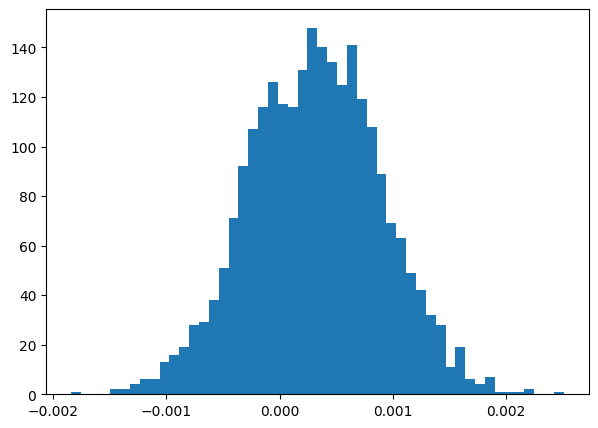

In [10]:
noise = torch.randn(1, 2431, 3, device=device)
fake = netG(noise).detach().cpu().reshape(2431).numpy()
plt.hist(fake, bins=50)
plt.show()

In [11]:
# spxusdfake = inverse(fake * spxusdmax, params)
spxusdfake = fake

In [12]:
spxusdfake.mean()

np.float32(0.00031325922)

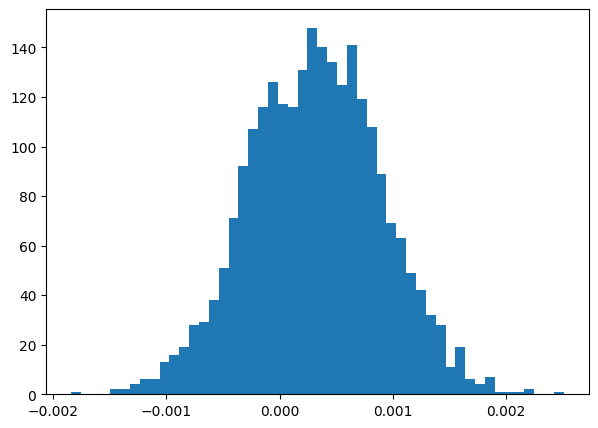

In [13]:
plt.hist(spxusdfake, bins=50)
plt.show()

In [ ]:
def generate_fakes(n=1, cumsum=True):
  fakes = []
  for i in range(n):
    noise = torch.randn(1, 300, 3, device=device)
    fake = netG(noise).detach().cpu().reshape(300).numpy()
    # sp500fake = inverse(fake * sp500max, params) + sp500log_mean
    fakes.append(fake)
  if n > 1:
    if not cumsum:
      return pd.DataFrame(fakes).T
    fakes_df = pd.DataFrame(fakes).T.cumsum()
    return fakes_df
  elif not cumsum:
    return fake
  return fake.cumsum()

In [23]:
generated_fakes = generate_fakes(200)
# print(type(generated_fakes))
# gen_torch = torch.from_numpy(generated_fakes.values).float()

# # Save the tensor to disk
# torch.save(gen_torch, 'generated_fakes.pt')

# loaded_gen_torch = torch.load('generated_fakes.pt')

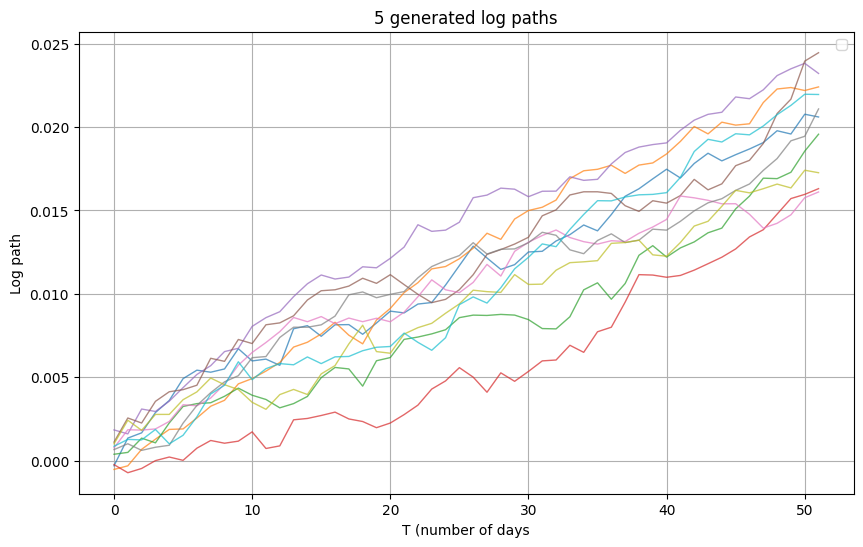

In [32]:
plt.figure(figsize=(10,6))
plt.plot(generate_fakes(10), linewidth=1, alpha=0.7)
plt.legend('')
plt.grid(True)
plt.xlabel('T (number of days')
plt.ylabel('Log path')
plt.title('5 generated log paths');

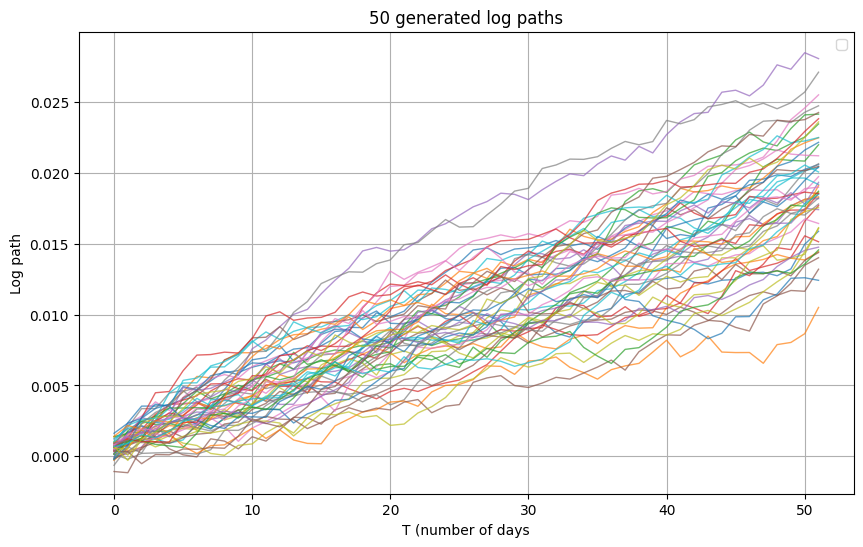

In [33]:
plt.figure(figsize=(10,6))
plt.plot(generate_fakes(50), linewidth=1, alpha=0.7)
plt.legend('')
plt.grid(True)
plt.xlabel('T (number of days')
plt.ylabel('Log path')
plt.title('50 generated log paths');

<Axes: >

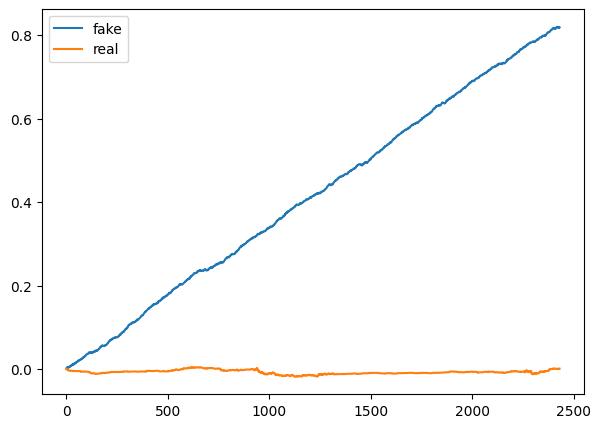

In [37]:
comp_df = pd.DataFrame({'fake': generate_fakes(), 'real': spxusdlog[:2432].cumsum()})
comp_df.plot()

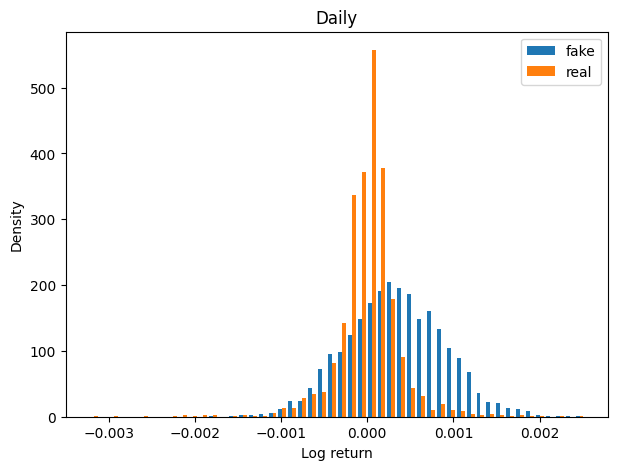

In [38]:
plt.hist([comp_df['fake'].diff(), comp_df['real'].diff()], bins=50, label=['fake', 'real'])
plt.legend(loc='upper right')
plt.xlabel('Log return')
plt.ylabel('Density')
plt.title('Daily')
plt.show()